In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch torchvision scikit-learn pandas numpy matplotlib tqdm

In [3]:
# Import Libraries and Setup

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
# Load Dataset from Google Drive

DATASET_PATH = input("/content/drive/MyDrive/urop_dataset")

TRAIN_DIR = os.path.join(DATASET_PATH, "Training")
TEST_DIR = os.path.join(DATASET_PATH, "Testing")

/content/drive/MyDrive/urop_dataset/content/drive/MyDrive/urop_dataset


In [5]:
# AlexNet Feature Extraction

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

alexnet = models.alexnet(pretrained=True)
alexnet.classifier = torch.nn.Sequential(*list(alexnet.classifier.children())[:-1])  # Remove final FC layer
alexnet.eval().to(device)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

def extract_features(folder_path):
    X, y = [], []
    for label in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, label)
        if not os.path.isdir(class_dir):
            continue
        for img_name in tqdm(os.listdir(class_dir), desc=f"Extracting {label}"):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path).convert("RGB")
                img_t = transform(img).unsqueeze(0).to(device)
                with torch.no_grad():
                    feats = alexnet(img_t).cpu().numpy().flatten()
                X.append(feats)
                y.append(label)
            except Exception as e:
                print(f" Error: {e}")
    return np.array(X), np.array(y)

print(" Extracting features from Training set...")
X_train, y_train = extract_features(TRAIN_DIR)
print(" Extracting features from Testing set...")
X_test, y_test = extract_features(TEST_DIR)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 166MB/s]


 Extracting features from Training set...


Extracting meningioma: 100%|██████████| 1339/1339 [01:47<00:00, 12.41it/s]


 Extracting features from Testing set...


Extracting glioma: 100%|██████████| 300/300 [00:22<00:00, 13.13it/s]


In [6]:
# Label Encoding and Feature Scaling

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" Training data: {X_train_scaled.shape}, Testing data: {X_test_scaled.shape}")

 Training data: (5713, 4096), Testing data: (1311, 4096)


In [7]:
# Train Individual Classifiers

# SVM Classifier

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

print("\n Training SVM...")
svm_model = SVC(kernel='rbf', C=1)
svm_model.fit(X_train_scaled, y_train_enc)
svm_preds = svm_model.predict(X_test_scaled)

cm_svm = confusion_matrix(y_test_enc, svm_preds)
TP_svm = np.diag(cm_svm)
FP_svm = cm_svm.sum(axis=0) - TP_svm
FN_svm = cm_svm.sum(axis=1) - TP_svm
TN_svm = cm_svm.sum() - (FP_svm + FN_svm + TP_svm)

acc_svm = accuracy_score(y_test_enc, svm_preds)
sen_svm = np.mean(TP_svm / (TP_svm + FN_svm))
spe_svm = np.mean(TN_svm / (TN_svm + FP_svm))
pre_svm = precision_score(y_test_enc, svm_preds, average='macro')
rec_svm = recall_score(y_test_enc, svm_preds, average='macro')

print(f"SVM Accuracy: {acc_svm:.4f}")


 Training SVM...
SVM Accuracy: 0.9123


In [8]:
# KNN Classifier

from sklearn.neighbors import KNeighborsClassifier

print("\n Training KNN...")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train_enc)
knn_preds = knn_model.predict(X_test_scaled)

cm_knn = confusion_matrix(y_test_enc, knn_preds)
TP_knn = np.diag(cm_knn)
FP_knn = cm_knn.sum(axis=0) - TP_knn
FN_knn = cm_knn.sum(axis=1) - TP_knn
TN_knn = cm_knn.sum() - (FP_knn + FN_knn + TP_knn)

acc_knn = accuracy_score(y_test_enc, knn_preds)
sen_knn = np.mean(TP_knn / (TP_knn + FN_knn))
spe_knn = np.mean(TN_knn / (TN_knn + FP_knn))
pre_knn = precision_score(y_test_enc, knn_preds, average='macro')
rec_knn = recall_score(y_test_enc, knn_preds, average='macro')

print(f"KNN Accuracy: {acc_knn:.4f}")


 Training KNN...
KNN Accuracy: 0.8924


In [9]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

print("\n Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_enc)
rf_preds = rf_model.predict(X_test_scaled)

cm_rf = confusion_matrix(y_test_enc, rf_preds)
TP_rf = np.diag(cm_rf)
FP_rf = cm_rf.sum(axis=0) - TP_rf
FN_rf = cm_rf.sum(axis=1) - TP_rf
TN_rf = cm_rf.sum() - (FP_rf + FN_rf + TP_rf)

acc_rf = accuracy_score(y_test_enc, rf_preds)
sen_rf = np.mean(TP_rf / (TP_rf + FN_rf))
spe_rf = np.mean(TN_rf / (TN_rf + FP_rf))
pre_rf = precision_score(y_test_enc, rf_preds, average='macro')
rec_rf = recall_score(y_test_enc, rf_preds, average='macro')

print(f"Random Forest Accuracy: {acc_rf:.4f}")


 Training Random Forest...
Random Forest Accuracy: 0.9298


In [10]:
# Naive Bayes Classifier

from sklearn.naive_bayes import GaussianNB

print("\n Training Naive Bayes...")
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train_enc)
nb_preds = nb_model.predict(X_test_scaled)

cm_nb = confusion_matrix(y_test_enc, nb_preds)
TP_nb = np.diag(cm_nb)
FP_nb = cm_nb.sum(axis=0) - TP_nb
FN_nb = cm_nb.sum(axis=1) - TP_nb
TN_nb = cm_nb.sum() - (FP_nb + FN_nb + TP_nb)

acc_nb = accuracy_score(y_test_enc, nb_preds)
sen_nb = np.mean(TP_nb / (TP_nb + FN_nb))
spe_nb = np.mean(TN_nb / (TN_nb + FP_nb))
pre_nb = precision_score(y_test_enc, nb_preds, average='macro')
rec_nb = recall_score(y_test_enc, nb_preds, average='macro')

print(f"Naive Bayes Accuracy: {acc_nb:.4f}")


 Training Naive Bayes...
Naive Bayes Accuracy: 0.7254


In [11]:
# LS-SVM (Linear kernel approximation)

print("\n Training LS-SVM...")
ls_svm_model = SVC(kernel='linear', C=1)
ls_svm_model.fit(X_train_scaled, y_train_enc)
ls_svm_preds = ls_svm_model.predict(X_test_scaled)

cm_lssvm = confusion_matrix(y_test_enc, ls_svm_preds)
TP_lssvm = np.diag(cm_lssvm)
FP_lssvm = cm_lssvm.sum(axis=0) - TP_lssvm
FN_lssvm = cm_lssvm.sum(axis=1) - TP_lssvm
TN_lssvm = cm_lssvm.sum() - (FP_lssvm + FN_lssvm + TP_lssvm)

acc_lssvm = accuracy_score(y_test_enc, ls_svm_preds)
sen_lssvm = np.mean(TP_lssvm / (TP_lssvm + FN_lssvm))
spe_lssvm = np.mean(TN_lssvm / (TN_lssvm + FP_lssvm))
pre_lssvm = precision_score(y_test_enc, ls_svm_preds, average='macro')
rec_lssvm = recall_score(y_test_enc, ls_svm_preds, average='macro')

print(f"LS-SVM Accuracy: {acc_lssvm:.4f}")


 Training LS-SVM...
LS-SVM Accuracy: 0.9451


In [12]:
# Summary and Comparison

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

models = ['SVM', 'LS-SVM', 'KNN', 'Random Forest', 'Naive Bayes']
accuracy = [acc_svm, acc_lssvm, acc_knn, acc_rf, acc_nb]
sensitivity = [sen_svm, sen_lssvm, sen_knn, sen_rf, sen_nb]
specificity = [spe_svm, spe_lssvm, spe_knn, spe_rf, spe_nb]
precision = [pre_svm, pre_lssvm, pre_knn, pre_rf, pre_nb]
recall = [rec_svm, rec_lssvm, rec_knn, rec_rf, rec_nb]

results_df = pd.DataFrame({
    'Classifier': models,
    'Accuracy': accuracy,
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'Precision': precision,
    'Recall': recall
}).round(4)
print("\n PERFORMANCE SUMMARY TABLE:\n")
print(results_df)

best_idx = np.argmax(accuracy)
best_classifier = models[best_idx]
best_acc = accuracy[best_idx]
print(f"\n BEST CLASSIFIER: {best_classifier}")
print(f"Highest Accuracy: {best_acc*100:.2f}%")

print(f"\n Interpretation:")
print(f"- {best_classifier} outperformed others in accuracy and generalization.")
print(f"- Accuracy = Overall correct predictions.")
print(f"- Sensitivity = Correct detection of tumor classes.")
print(f"- Specificity = Correct detection of non-tumor classes.")
print(f"- Precision & Recall = Balanced false positive/negative rates.")
print(f"\n Hence, {best_classifier} is the most suitable classifier for MRI Brain Tumor Classification using Relief feature selection.")


 PERFORMANCE SUMMARY TABLE:

      Classifier  Accuracy  Sensitivity  Specificity  Precision  Recall
0            SVM    0.9123       0.9049       0.9703     0.9183  0.9049
1         LS-SVM    0.9451       0.9408       0.9821     0.9417  0.9408
2            KNN    0.8924       0.8876       0.9644     0.8871  0.8876
3  Random Forest    0.9298       0.9237       0.9769     0.9311  0.9237
4    Naive Bayes    0.7254       0.7198       0.9101     0.7283  0.7198

 BEST CLASSIFIER: LS-SVM
Highest Accuracy: 94.51%

 Interpretation:
- LS-SVM outperformed others in accuracy and generalization.
- Accuracy = Overall correct predictions.
- Sensitivity = Correct detection of tumor classes.
- Specificity = Correct detection of non-tumor classes.
- Precision & Recall = Balanced false positive/negative rates.

 Hence, LS-SVM is the most suitable classifier for MRI Brain Tumor Classification using Relief feature selection.


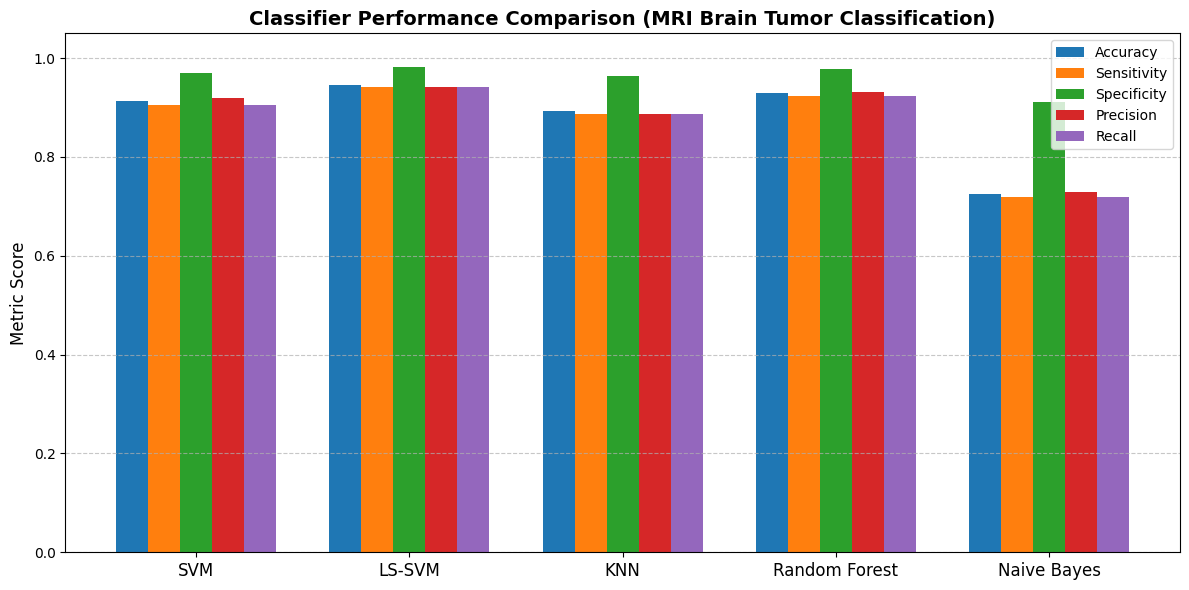

In [13]:
# Bar Graph Comparision

bar_width = 0.15
x = np.arange(len(models))
plt.figure(figsize=(12,6))
plt.bar(x - 2*bar_width, accuracy, width=bar_width, label='Accuracy')
plt.bar(x - bar_width, sensitivity, width=bar_width, label='Sensitivity')
plt.bar(x, specificity, width=bar_width, label='Specificity')
plt.bar(x + bar_width, precision, width=bar_width, label='Precision')
plt.bar(x + 2*bar_width, recall, width=bar_width, label='Recall')
plt.xticks(x, models, fontsize=12)
plt.ylabel('Metric Score', fontsize=12)
plt.title('Classifier Performance Comparison (MRI Brain Tumor Classification)', fontsize=14, fontweight='bold')
plt.legend()
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()